In [60]:
# 5.2 MNISTデータセットの特徴まで

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tensorflow.examples.tutorials.mnist import input_data
from pathlib import Path


In [62]:
# カレントスレッドにデフォルトのグラフが残存していることがあるので、リセットする
tf.reset_default_graph()

In [63]:
sess = tf.InteractiveSession()

C:\Users\210450279\Anaconda3\envs\rebases\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [64]:
# 再現性の確保のために乱数シードを固定(数値は何でもよい)
tf.set_random_seed(12345)

In [65]:
# 入力データ
# MNISTのone-hot表現での読み込み
# validation_sizeを指定することで、トレーニングセット60,000枚から5,000枚をバリデーションセットに割り当てることができる。
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, validation_size=10000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [66]:
# 入力画像
# プレースホルダー型で・・・
x = tf.placeholder(tf.float32, name='x', shape=[None, 784])

In [67]:
# サイズ変更
x_1 = tf.reshape(x, [-1, 28, 28, 1])

In [68]:
# ランダムカーネル
k_0 = tf.Variable(tf.truncated_normal([4, 4, 1, 10], mean=0.0, stddev=0.1))

# 畳み込み
x_2 = tf.nn.conv2d(x_1, k_0, strides=[1, 3, 3, 1], padding='VALID')

In [69]:
# 活性化関数
x_3 = tf.nn.relu(x_2)

In [70]:
# プーリング
x_4 = tf.nn.max_pool(x_3, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')

In [71]:
# サイズ変更
x_5 = tf.reshape(x_4, [-1, 160])

In [72]:
# ドロップアウト付きの全結合
# tf.nn.dropout()の引数のkeep_propにノードを残す割合を指定する
def matmul_plus_bias_with_dropout(x, w, b, p):
    return tf.matmul(tf.nn.dropout(x, keep_prob=p), w) + b

In [73]:
# そのまま出力すると、データフローグラフのノードがそのままバラバラに表示されてしまい、見づらい。
# tf.name_scope() : 名前スコープを定義し、表示単位を引数の名前でまとめることができる。
with tf.name_scope('prediction_1'):
    # 重みとバイアス
    w_1 = tf.Variable(tf.zeros([160, 40]))
    b_1 = tf.Variable([0.1] * 40)

    # ドロップアウト率
    p_1 = tf.placeholder(1.0, name='p_1')

    # 全結合
    # x_6 = tf.matmul(x_5, w_1) + b_1
    x_6 = matmul_plus_bias_with_dropout(x_5, w_1, b_1, p_1)

In [74]:
# 活性化関数
x_7 = tf.nn.relu(x_6)

In [75]:
# そのまま出力すると、データフローグラフのノードがそのままバラバラに表示されてしまい、見づらい。
# tf.name_scope() : 名前スコープを定義し、表示単位を引数の名前でまとめることができる。
with tf.name_scope('prediction_2'):
    # 重みとバイアス
    w_2 = tf.Variable(tf.zeros([40, 10]))
    b_2 = tf.Variable([0.1] * 10)

    # ドロップアウト率
    p_2 = tf.placeholder(1.0, name='p_2')

    # 全結合
    # x_8 = tf.matmul(x_7, w_2) + b_2
    x_8 = matmul_plus_bias_with_dropout(x_7, w_2, b_2, p_2)

In [76]:
# 確率化
y = tf.nn.softmax(x_8, name="y")

In [77]:
# 損失関数の最小化

# 正解ラベル
labels = tf.placeholder(tf.float32, name='labels', shape=[None, 10])

# 損失関数(交差エントロピー誤差)
# tf.reduce_sum() : 与えたリストに入っている数値の合計を求めるメソッド
# loss = -tf.reduce_sum(labels * tf.log(y))
loss = -tf.reduce_sum(labels * tf.log(y + 1e-9)) / tf.cast(tf.shape(y)[0], tf.float32)

# 最適化処理(Adam)
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [78]:
# 精度検証

# tf.equal(x, y) : xとyが等しければTrue、等しくなければFalseを返す
prediction_match = tf.equal(tf.argmax(y, axis=1), tf.argmax(labels, axis=1))

# tf.reduce_mean() : 与えたリストに入っている数値の平均値を求めるメソッド
# tf.cast() : 型を変換するメソッド　以下では第1引数がTrueなら、
# それを第2引数のfloat型に変換する
accuracy = tf.reduce_mean(tf.cast(prediction_match, tf.float32), name = "accuracy")

In [79]:
# 損失関数の出力をトレース対象とする
# tf.summary.scalar() :  損失関数の出力すなわちスカラー値を可視化する
tf.summary.scalar('loss_1', loss)

# # 精度の出力をトレース対象とする
# # tf.summary.scalar() :  精度の出力すなわちスカラー値を可視化する
tf.summary.scalar('accuracy_1', accuracy)

# 複数のログ('loss_1'と'accuracy_1')をmergedにまとめる
# tf.summary.merge_all() : 複数のスカラー値を1つの変数にマージする
# tf.summary.merge() : すべての変数ではなく明示的に変数をまとめるときに使う
merged = tf.summary.merge_all()

In [80]:
# パラメータ

# バッチサイズ
BATCH_SIZE = 32  
 
# 学習回数
NUM_TRAIN = 10_000  # 10_000 は 10,000 と同義

# 学習中の出力精度
OUTPUT_BY = 500

# ドロップアウト率
DROPOUT_PROB_1 = 0.2
DROPOUT_PROB_2 = 0.5

In [81]:
# 以前のログが残っていれば削除する（通常は残すようにしてください）
logdir = Path('logs/log1')
if logdir.exists():
    shutil.rmtree(str(logdir))

In [85]:
# logsディレクトリに出力するライターを作成して利用
# tf.summary.FileWriter : ログを出力するためのクラス
# インスタンス作成後に add_graph()を用いると、データフローグラフを可視化できる。
# 今回は省略しているが、各テンソルに名前を付けておけば、その名前が可視化の際に利用される。
with tf.summary.FileWriter('logs/log1/train', sess.graph) as writer:
    # 学習の実行
    sess.run(tf.global_variables_initializer())
    dropout_prob = {p_1 : DROPOUT_PROB_1, p_2 : DROPOUT_PROB_2}

    # TensorFlowでは、モデルのファイル入出力は tf.train.Saver() を使う
    saver = tf.train.Saver()

    for i in range(NUM_TRAIN):
        # MNISTの訓練データから複数の画像データとラベルデータを取得(ミニバッチ学習)
        batch_train = mnist.train.next_batch(BATCH_SIZE)
        inout_train = {x : batch_train[0], labels : batch_train[1]}
        # MNISTのバリデーションデータから複数の画像データとラベルデータを取得(ミニバッチ学習)
        batch_val = mnist.validation.next_batch(BATCH_SIZE)
        inout_val = {x : batch_val[0], labels : batch_val[1]}
        
        summary, mae, _ = sess.run([merged, loss, optimizer],\
            feed_dict={x:batch_train[0], labels:batch_train[1], p_1 : 1.0, p_2 : 1.0})
            

        if i % OUTPUT_BY == 0:
            train_accuracy = accuracy.eval(feed_dict = {**inout_train, p_1 : 1.0, p_2 : 1.0})
            val_accuracy = accuracy.eval(feed_dict = {**inout_val, p_1 : 1.0, p_2 : 1.0})
            train_loss = loss.eval(feed_dict = {**inout_train, p_1 : 1.0, p_2 : 1.0})
            val_loss = loss.eval(feed_dict = {**inout_val, p_1 : 1.0, p_2 : 1.0})
            writer.add_summary(summary, global_step=i)
            print('step {:d}, train_loss {:.2f}, val_loss {:.2f}, train_acc {:.2f}, val_acc {:.2f}'.format(
                i, train_loss, val_loss, train_accuracy, val_accuracy))
            writer.add_summary(summary, global_step=i)
            saver.save(sess, 'model1/my-model')
        optimizer.run(feed_dict={**inout_train, **dropout_prob})
    
    
    
    # ログの出力
    # add_summary() : スカラー値のログを出力するためのメソッド
    writer.add_summary(summary, global_step=NUM_TRAIN)

    # 最終結果の保存
    saver.save(sess, 'model1/my-model')

# ----------------------------------------------------------------------------------
# modelsの中に .data-00000-of-00001/.index/.meta という3つの拡張子が
# 付いたファイル群とcheckpointファイルが作成される
# 「過程の保存」では、ファイル名には「<モデル名>-<ステップ数>.<拡張子>」という名前で保存。
# 「最終結果の保存」では、ファイル名には「<モデル名>.<拡張子>」という名前で保存。

# .metaファイルは、メタグラフというデータフローグラフ構造などの情報を保存したもの。
# -----------------------------------------------------------------------------------

step 0, train_loss 2.30, val_loss 2.30, train_acc 0.16, val_acc 0.16
step 500, train_loss 1.08, val_loss 1.02, train_acc 0.72, val_acc 0.75
step 1000, train_loss 0.91, val_loss 0.84, train_acc 0.72, val_acc 0.81
step 1500, train_loss 0.53, val_loss 0.52, train_acc 0.91, val_acc 0.91
step 2000, train_loss 0.65, val_loss 0.49, train_acc 0.84, val_acc 0.94
step 2500, train_loss 0.53, val_loss 0.48, train_acc 0.84, val_acc 0.91
step 3000, train_loss 0.77, val_loss 0.71, train_acc 0.78, val_acc 0.81
step 3500, train_loss 0.57, val_loss 0.52, train_acc 0.81, val_acc 0.91
step 4000, train_loss 0.55, val_loss 0.48, train_acc 0.84, val_acc 0.84
step 4500, train_loss 0.50, val_loss 0.40, train_acc 0.84, val_acc 0.94
step 5000, train_loss 0.42, val_loss 0.35, train_acc 0.91, val_acc 0.97
step 5500, train_loss 0.47, val_loss 0.34, train_acc 0.91, val_acc 0.97
step 6000, train_loss 0.28, val_loss 0.27, train_acc 0.97, val_acc 0.94
step 6500, train_loss 0.36, val_loss 0.68, train_acc 0.88, val_acc 0

In [86]:
# テストデータによる精度検証
test_accuracy = accuracy.eval(feed_dict={x : mnist.test.images,\
    labels : mnist.test.labels, p_1 : 1.0, p_2 :1.0})
print('test_accuracy{:.2f}'.format(test_accuracy))

test_accuracy0.92


In [87]:
# 上記はテンソルを用いて正解率を計算しているが、次のようにNumpy形式で正解率を計算することもできる。

# test_y は予測結果。
test_y = y.eval(feed_dict={x: mnist.test.images, p_1: 1.0, p_2: 1.0}).argmax(axis=1)

# test_labels は正解ラベル。
test_labels = mnist.test.labels.argmax(axis=1)

# 予測結果と正解ラベルから、正解率を計算する。
test_accuracy = np.sum(test_y == test_labels) / float(test_y.shape[0])
print('test accuracy {:.2f}'.format(test_accuracy))

test accuracy 0.92


In [88]:
# ラベル名の一覧を取得
label_names = list(range(mnist.test.labels.shape[1]))

# 混同行列(confusion_matrix())を出力
import sklearn

test_confusion_matrix = sklearn.metrics.confusion_matrix(test_labels, test_y, labels=label_names)
print('test confusion matrix:\n{}'.format(str(test_confusion_matrix)))

test confusion matrix:
[[ 937    4    4    3    0    0   22    2    6    2]
 [   4 1094    9    2    3    0   10    1   10    2]
 [  20    0  949   19    7    0    4    7   25    1]
 [   1    0    9  961    0   12    0    3   14   10]
 [   0    1    2    0  926    0   14    3    5   31]
 [   4    0    1   36    0  814    6    0   25    6]
 [  20    3    5    0    6   21  888    0   15    0]
 [   1    3   31   13    6    0    0  899   13   62]
 [  32    5   10   30    7   35   17   13  801   24]
 [   6    7    1   16   17   16    2   13   23  908]]


In [89]:
# 正解率(accuracy_score())を出力
test_test_accuracy = sklearn.metrics.accuracy_score(test_labels, test_y)
print('accuracy:\n{}'.format(str(test_test_accuracy)))

# 適合率(precision_score())を出力
test_precision = sklearn.metrics.precision_score(test_labels, test_y, average=None)
print('precision:\n{}'.format(str(test_precision)))

# 再現率(recall_score())を出力
test_recall = sklearn.metrics.recall_score(test_labels, test_y, average=None)
print('recall:\n{}'.format(str(test_recall)))

# F値(f1_score())を出力
# (1)メソッドからF値を計算
test_f1_1 = sklearn.metrics.f1_score(test_labels, test_y, average=None)
print('f1 score:\n{}'.format(str(test_f1_1)))
# (2)適合率と再現率を使って、数式でF値を計算
test_f1_2 = 2 * ((test_precision * test_recall)/(test_precision + test_recall))
print('f1 score:\n{}'.format(str(test_f1_2)))

accuracy:
0.9177
precision:
[0.91414634 0.97940913 0.9294809  0.88981481 0.9526749  0.9064588
 0.92211838 0.95536663 0.85485592 0.86806883]
recall:
[0.95612245 0.96387665 0.91957364 0.95148515 0.94297352 0.91255605
 0.92693111 0.87451362 0.82238193 0.89990089]
f1 score:
[0.93466334 0.97158082 0.92450073 0.91961722 0.94779939 0.90949721
 0.92451848 0.91315389 0.83830455 0.8836983 ]
f1 score:
[0.93466334 0.97158082 0.92450073 0.91961722 0.94779939 0.90949721
 0.92451848 0.91315389 0.83830455 0.8836983 ]


Text(0, 0.5, 'counts')

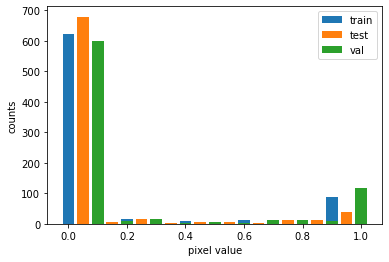

In [90]:
# MNISTデータセットについて、トレーニング用画像・テスト用画像それぞれの画素値を取得し、ヒストグラムを描画
# mnist.train.images[0]は1枚目の画像のこと
(train_hist, train_bins, _) = plt.hist(mnist.train.images[0], label="train", align='left', rwidth=0.4)
(test_hist, test_bins, _) = plt.hist(mnist.test.images[0], label="test", align="mid", rwidth=0.4)
(val_hist, val_bins, _) = plt.hist(mnist.validation.images[0], label="val", align="right", rwidth=0.4)

plt.legend(loc="upper right")
plt.xlabel("pixel value")
plt.ylabel("counts")